## Attack in deep learning


*   This code is dedicated to the attack (recover) of data from trained model



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Code for training

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a simple neural network for MNIST
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Load and preprocess MNIST data
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False
    )

    return train_loader, test_loader, train_dataset, test_dataset

# Train the model
def train_model(model, train_loader, epochs=5):
    model = model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate loss using raw logits (before softmax)
            loss = criterion(model.fc3(model.relu2(model.fc2(model.relu1(model.fc1(model.flatten(inputs)))))), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/100:.4f}, Accuracy: {100*correct/total:.2f}%')
                running_loss = 0.0

        print(f'Epoch {epoch+1} completed, Accuracy: {100*correct/total:.2f}%')

    print('Training completed!')
    return model

In [ ]:
# Load data
train_loader, test_loader, train_dataset, test_dataset = load_data()

# Train model
print("Training model...")
model = train_model(MNISTModel, train_loader)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.87MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.23MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training model...
Epoch 1, Batch 100, Loss: 1.0042, Accuracy: 73.56%
Epoch 1, Batch 200, Loss: 0.3882, Accuracy: 81.05%
Epoch 1, Batch 300, Loss: 0.3004, Accuracy: 84.52%
Epoch 1, Batch 400, Loss: 0.2679, Accuracy: 86.45%
Epoch 1, Batch 500, Loss: 0.2597, Accuracy: 87.62%
Epoch 1, Batch 600, Loss: 0.2193, Accuracy: 88.62%
Epoch 1, Batch 700, Loss: 0.2096, Accuracy: 89.40%
Epoch 1, Batch 800, Loss: 0.2114, Accuracy: 89.94%
Epoch 1, Batch 900, Loss: 0.1902, Accuracy: 90.47%
Epoch 1 completed, Accuracy: 90.62%
Epoch 2, Batch 100, Loss: 0.1458, Accuracy: 95.80%
Epoch 2, Batch 200, Loss: 0.1434, Accuracy: 95.83%
Epoch 2, Batch 300, Loss: 0.1452, Accuracy: 95.74%
Epoch 2, Batch 400, Loss: 0.1354, Accuracy: 95.78%
Epoch 2, Batch 500, Loss: 0.1360, Accuracy: 95.83%
Epoch 2, Batch 600, Loss: 0.1438, Accuracy: 95.80%
Epoch 2, Batch 700, Loss: 0.1391, Accuracy: 95.76%
Epoch 2, Batch 800, Loss: 0.1351, Accuracy: 95.80%
Epoc

# Code for attacking

In [ ]:
# Data recovery attack via model inversion
def model_inversion_attack(model, target_class, learning_rate=0.01, iterations=5000):
    """
    Attempts to reconstruct a representative sample from target_class
    by optimizing an input to maximize the target class probability
    """
    model.eval()  # Set model to evaluation mode

    # Start with random noise as our initial image
    recovered_image = torch.rand(1, 1, 28, 28, requires_grad=True, device=device)

    # Define optimizer for the image
    optimizer = optim.Adam([recovered_image], lr=learning_rate)

    # Create one-hot vector for target class
    target = torch.zeros(1, 10, device=device)
    target[0, target_class] = 1

    losses = []

    # Optimization loop
    for i in range(iterations):
        optimizer.zero_grad()

        # Get model prediction
        pred = model(recovered_image)

        # Calculate loss (negative log likelihood of target class)
        classification_loss = -torch.sum(target * torch.log(pred + 1e-10))

        # Add regularization to encourage a cleaner image
        tv_loss = torch.sum(torch.abs(recovered_image[:, :, :, :-1] - recovered_image[:, :, :, 1:])) + \
                  torch.sum(torch.abs(recovered_image[:, :, :-1, :] - recovered_image[:, :, 1:, :]))
        tv_loss = tv_loss * 0.001

        l2_loss = torch.sum(recovered_image ** 2) * 0.001

        total_loss = classification_loss + tv_loss  + l2_loss

        # Backward pass
        total_loss.backward()

        # Update the image
        optimizer.step()

        # Clip values to valid image range [0, 1]
        with torch.no_grad():
            recovered_image.clamp_(0, 1)

        # Track progress
        if i % 100 == 0:
            losses.append(classification_loss.item())
            print(f"Iteration {i}, Loss: {classification_loss.item():.4f}")

    # Get the final recovered image
    with torch.no_grad():
        recovered_image_np = recovered_image.cpu().squeeze().numpy()

    return recovered_image_np, losses

# Display results
def plot_recovered_images(original_samples, recovered_images, target_classes):
    plt.figure(figsize=(12, 4))

    for i, (orig, rec, target) in enumerate(zip(original_samples, recovered_images, target_classes)):
        # Plot original
        plt.subplot(2, len(target_classes), i + 1)
        plt.imshow(orig, cmap='gray')
        plt.title(f"Original Class {target}")
        plt.axis('off')

        # Plot recovered
        plt.subplot(2, len(target_classes), i + len(target_classes) + 1)
        plt.imshow(rec, cmap='gray')
        plt.title(f"Recovered Class {target}")
        plt.axis('off')a

    plt.tight_layout()
    plt.show()


Performing model inversion attack for class 0...
Iteration 0, Loss: 22.8719
Iteration 100, Loss: 0.0000
Iteration 200, Loss: 0.0000
Iteration 300, Loss: 0.0001
Iteration 400, Loss: 0.0001
Iteration 500, Loss: 0.0004
Iteration 600, Loss: 0.0008
Iteration 700, Loss: 0.0014
Iteration 800, Loss: 0.0017
Iteration 900, Loss: 0.0020
Iteration 1000, Loss: 0.0021
Iteration 1100, Loss: 0.0023
Iteration 1200, Loss: 0.0025
Iteration 1300, Loss: 0.0028
Iteration 1400, Loss: 0.0033
Iteration 1500, Loss: 0.0034
Iteration 1600, Loss: 0.0037
Iteration 1700, Loss: 0.0038
Iteration 1800, Loss: 0.0040
Iteration 1900, Loss: 0.0041
Iteration 2000, Loss: 0.0039
Iteration 2100, Loss: 0.0040
Iteration 2200, Loss: 0.0041
Iteration 2300, Loss: 0.0041
Iteration 2400, Loss: 0.0042
Iteration 2500, Loss: 0.0044
Iteration 2600, Loss: 0.0046
Iteration 2700, Loss: 0.0047
Iteration 2800, Loss: 0.0047
Iteration 2900, Loss: 0.0048
Iteration 3000, Loss: 0.0048
Iteration 3100, Loss: 0.0047
Iteration 3200, Loss: 0.0047
Iter

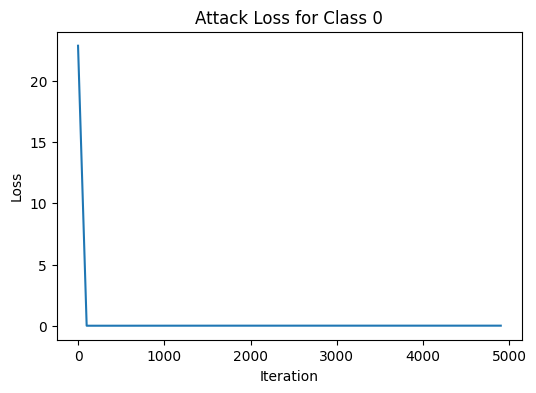


Performing model inversion attack for class 1...
Iteration 0, Loss: 16.6995
Iteration 100, Loss: 0.0014
Iteration 200, Loss: 0.0017
Iteration 300, Loss: 0.0025
Iteration 400, Loss: 0.0039
Iteration 500, Loss: 0.0051
Iteration 600, Loss: 0.0058
Iteration 700, Loss: 0.0064
Iteration 800, Loss: 0.0062
Iteration 900, Loss: 0.0063
Iteration 1000, Loss: 0.0064
Iteration 1100, Loss: 0.0064
Iteration 1200, Loss: 0.0063
Iteration 1300, Loss: 0.0069
Iteration 1400, Loss: 0.0077
Iteration 1500, Loss: 0.0079
Iteration 1600, Loss: 0.0080
Iteration 1700, Loss: 0.0073
Iteration 1800, Loss: 0.0067
Iteration 1900, Loss: 0.0064
Iteration 2000, Loss: 0.0059
Iteration 2100, Loss: 0.0036
Iteration 2200, Loss: 0.0040
Iteration 2300, Loss: 0.0043
Iteration 2400, Loss: 0.0043
Iteration 2500, Loss: 0.0043
Iteration 2600, Loss: 0.0043
Iteration 2700, Loss: 0.0043
Iteration 2800, Loss: 0.0043
Iteration 2900, Loss: 0.0043
Iteration 3000, Loss: 0.0043
Iteration 3100, Loss: 0.0043
Iteration 3200, Loss: 0.0043
Iter

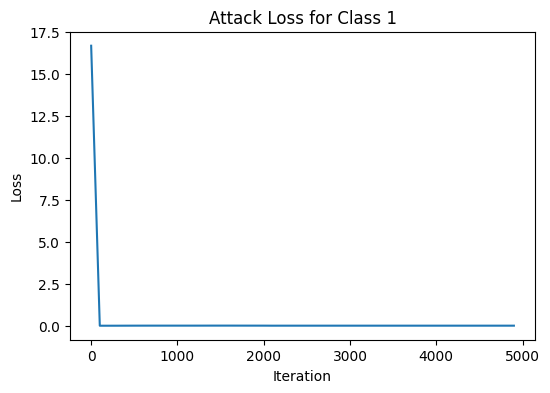


Performing model inversion attack for class 4...
Iteration 0, Loss: 23.0259
Iteration 100, Loss: 0.0009
Iteration 200, Loss: 0.0007
Iteration 300, Loss: 0.0007
Iteration 400, Loss: 0.0009
Iteration 500, Loss: 0.0014
Iteration 600, Loss: 0.0021
Iteration 700, Loss: 0.0027
Iteration 800, Loss: 0.0030
Iteration 900, Loss: 0.0021
Iteration 1000, Loss: 0.0021
Iteration 1100, Loss: 0.0020
Iteration 1200, Loss: 0.0021
Iteration 1300, Loss: 0.0023
Iteration 1400, Loss: 0.0024
Iteration 1500, Loss: 0.0026
Iteration 1600, Loss: 0.0028
Iteration 1700, Loss: 0.0033
Iteration 1800, Loss: 0.0035
Iteration 1900, Loss: 0.0036
Iteration 2000, Loss: 0.0038
Iteration 2100, Loss: 0.0038
Iteration 2200, Loss: 0.0039
Iteration 2300, Loss: 0.0039
Iteration 2400, Loss: 0.0036
Iteration 2500, Loss: 0.0034
Iteration 2600, Loss: 0.0035
Iteration 2700, Loss: 0.0035
Iteration 2800, Loss: 0.0035
Iteration 2900, Loss: 0.0035
Iteration 3000, Loss: 0.0035
Iteration 3100, Loss: 0.0035
Iteration 3200, Loss: 0.0035
Iter

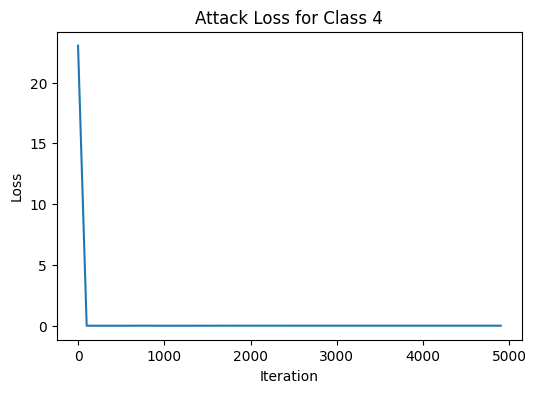


Performing model inversion attack for class 8...
Iteration 0, Loss: 22.4877
Iteration 100, Loss: 0.0005
Iteration 200, Loss: 0.0007
Iteration 300, Loss: 0.0007
Iteration 400, Loss: 0.0009
Iteration 500, Loss: 0.0013
Iteration 600, Loss: 0.0016
Iteration 700, Loss: 0.0016
Iteration 800, Loss: 0.0016
Iteration 900, Loss: 0.0016
Iteration 1000, Loss: 0.0018
Iteration 1100, Loss: 0.0019
Iteration 1200, Loss: 0.0023
Iteration 1300, Loss: 0.0027
Iteration 1400, Loss: 0.0030
Iteration 1500, Loss: 0.0032
Iteration 1600, Loss: 0.0032
Iteration 1700, Loss: 0.0031
Iteration 1800, Loss: 0.0032
Iteration 1900, Loss: 0.0034
Iteration 2000, Loss: 0.0035
Iteration 2100, Loss: 0.0037
Iteration 2200, Loss: 0.0039
Iteration 2300, Loss: 0.0041
Iteration 2400, Loss: 0.0042
Iteration 2500, Loss: 0.0042
Iteration 2600, Loss: 0.0042
Iteration 2700, Loss: 0.0042
Iteration 2800, Loss: 0.0042
Iteration 2900, Loss: 0.0042
Iteration 3000, Loss: 0.0042
Iteration 3100, Loss: 0.0042
Iteration 3200, Loss: 0.0042
Iter

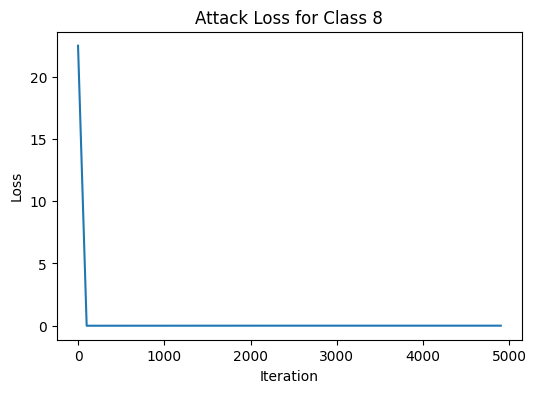

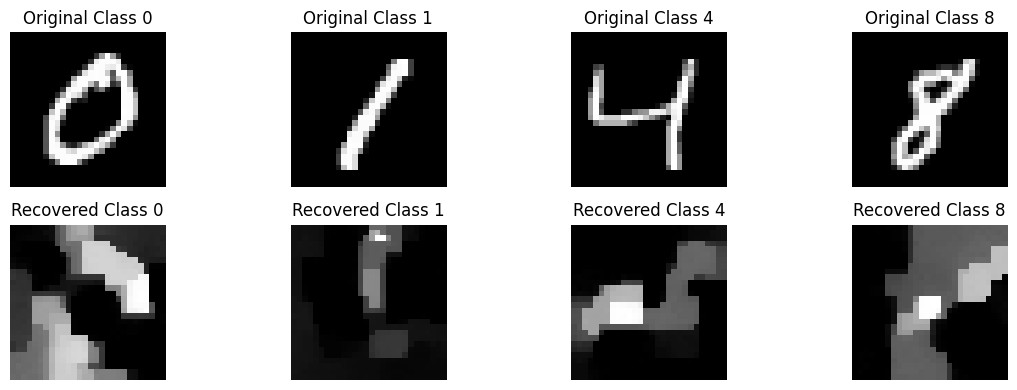


Attack completed. The recovered images represent information leaked from the model.


In [ ]:
# Select target classes to recover
target_classes = [0, 1, 4, 8]  # Digits to recover: 0, 1, 4, 8

# Get example images from each target class
original_samples = []
for target in target_classes:
    for img, label in train_dataset:
        if label == target:
            original_samples.append(img.squeeze().numpy())
            break

    # Perform model inversion attack for each target class
recovered_images = []
for target in target_classes:
    print(f"\nPerforming model inversion attack for class {target}...")
    recovered_image, losses = model_inversion_attack(model, target)
    recovered_images.append(recovered_image)

    # Plot loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(0, len(losses) * 100, 100), losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Attack Loss for Class {target}')
    plt.show()

# Plot results
plot_recovered_images(original_samples, recovered_images, target_classes)

print("\nAttack completed. The recovered images represent information leaked from the model.")


# Mission 1



*   Try to explain the what we are doing in these codes
*   Try to explain the importance of this topic



# Mission 2



*   Change the hyper-parameters in the following attacking function
*   Compare the results of different hyper-parameters
*   Explain the mechanism of this attacking function

